# Comparison between artifical language and natural language
## A comparison between PCFG generated data and the Penn Tree Bank data

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.patches as mpatches
import os
import string
import scipy.optimize as opt
import matplotlib.colors as mcolors
import random

In [4]:
PTB = []
sentences_results_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/PTB/penn-sentences.txt')
with open(sentences_results_path) as f:
    for i, sentence in enumerate(f.readlines()):
        PTB.append(sentence.split(' '))

In [5]:
AL = []
AL_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/corpora/eval.txt')
with open(AL_path) as f:
    for i, sentence in enumerate(f.readlines()):
        AL.append(sentence.split(' '))

## Length of sentences

In [6]:
def stats_dataset(dataset):
    print(
    f"""The length of the AL corpus is {len(dataset)}.
    The maximum length is {max(dataset)}. 
    The minimum length is {min(dataset)}.""")

In [7]:
lengthsAL = [len(i) for i in AL]
stats_dataset(lengthsAL)

The length of the AL corpus is 10000.
    The maximum length is 19. 
    The minimum length is 7.


In [8]:
# PTB
cutoff_max = 20
cutoff_min = 6
lengthsPTB = [len(i) for i in PTB if len(i) < cutoff_max and len(i) > cutoff_min]
stats_dataset(lengthsPTB)

The length of the AL corpus is 11406.
    The maximum length is 19. 
    The minimum length is 7.


In [9]:
def plot_length_dist(dataset, name):
    # plot smooth distribution of sentence lengths
    density = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), len(dataset))

    plt.hist(dataset, bins=10, density=True, alpha=0.7, label='PTB')
    plt.plot(x, density(x), color='#FF7F0E')
    plt.fill_between(x, density(x), alpha=0.5, color='#FF7F0E')
    plt.title(f'Distribution of sentence lengths of {name}')

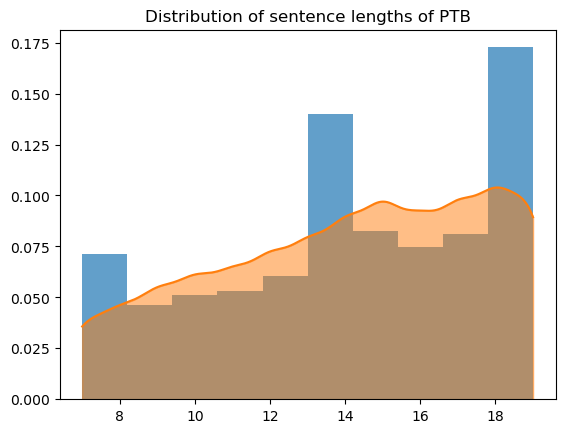

In [10]:
plot_length_dist(lengthsPTB, 'PTB')

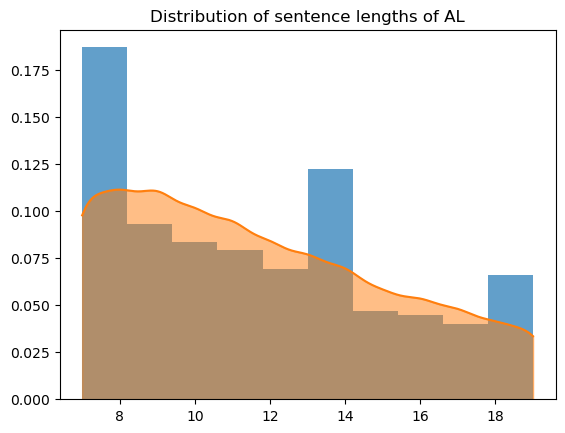

In [11]:
plot_length_dist(lengthsAL, 'AL')

In [12]:
def plot_comparison_dist(dataset1, dataset2, name1, name2):
    # plot smooth distribution of sentence lengths
    density1 = gaussian_kde(dataset1)
    density2 = gaussian_kde(dataset2)
    x1 = np.linspace(min(dataset1), max(dataset1), len(dataset1))
    x2 = np.linspace(min(dataset2), max(dataset2), len(dataset2))

    plt.plot(x1, density1(x1), color='#FF7F0E')
    plt.fill_between(x1, density1(x1), alpha=0.5, color='#FF7F0E')
    o_patch = mpatches.Patch(edgecolor='#FF7F0E', facecolor='#FFBF86', label=f'{name1}')

    plt.plot(x2, density2(x2), color='#1F77B4', label=f'Distr of {name2}')
    plt.fill_between(x2, density2(x2), alpha=0.5, color='#1F77B4')
    b_patch = mpatches.Patch(edgecolor='#1F77B4', facecolor='#8FBBD9', label=f'{name2}')

    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.get_yaxis().set_visible(False)   
    plt.xlabel('Sentence length')
    plt.title(f'Distribution of sentence lengths of {name1} and {name2}')
    plt.legend(handles=[o_patch, b_patch])

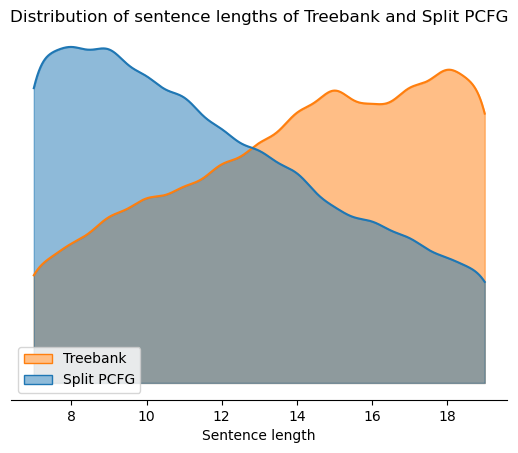

In [13]:
plot_comparison_dist(lengthsPTB, lengthsAL, 'Treebank', 'Split PCFG')

## Zipf curve

In [14]:
def create_vocab(data):
    unwantedCharacters = list(string.punctuation)

    vocab = defaultdict(int)
    # Cleaning and counting the Text
    for text in data:
        for word in text:
            # Remove unwanted characters from the texts
            if word in unwantedCharacters:
                text.remove(word)
                continue

            vocab[word] += 1

    return vocab


def zipf_equation(x, alpha, beta):
    return 1/(x+beta)**alpha


def Zipf_curve(data):
    vocab = create_vocab(data)

    freq = np.zeros(len(vocab.keys()))
    rank = np.zeros(len(vocab.keys()))
    for i, count in enumerate(vocab.values()):
        sample = np.random.binomial(count, 0.5)
        freq[i] = sample
        rank[i] = count - sample
    
    indices = np.argsort(rank)[::-1]
    rank = np.sort(rank[::-1])
    freq = freq[indices]
    freq = freq / np.linalg.norm(freq)
    x_values = np.arange(1, len(vocab.keys())+1)

    # Fit Eq. 2 to the data
    params, _ = opt.curve_fit(zipf_equation, x_values, freq, maxfev=10000)

    # Generate fitted line
    fitted_line = zipf_equation(x_values, *params)

    return x_values, freq, fitted_line, params

def plot_Zipf_curve_comparison(data1, data2, name1, name2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    data = [data1, data2]
    names = [name1, name2]

    # define color schema
    colors = ["blue", "lightgreen"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    for i, ax in enumerate([ax1, ax2]):
        # get the distribution over the data and the Zipf curve
        x_values, y_values, fitted_line, params = Zipf_curve(data[i])

        # plot the data and the fitted line
        ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
        ax.plot(np.log(x_values), np.log(fitted_line), color='red')

        # display the parameters of the fitted line
        ax.text(0.1, 0.05, f'α = {params[0]:.2f}\nβ = {params[1]:.2f}', transform=ax.transAxes, fontsize=8)

        # Customize the plots
        ax.set_xticks(np.arange(0, 12, 2))
        ax.tick_params(axis='both', which='both', labelcolor='gray', bottom=False, left=False)
        ax.spines[['right', 'top']].set_visible(False)

        # Labeling the plot
        ax.set_xlabel('Log frequency rank')
        ax.set_ylabel('Log normalized frequency')

        ax.set_title(f'{names[i]}')

    ax2.yaxis.get_label().set_visible(False)

def plot_Zipf_curve(data):
    plt.figure(figsize=(4, 4))
    colors = ["blue", "lightgreen"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    x_values, y_values, fitted_line, _ = Zipf_curve(data)

    # plot the data and the fitted line
    plt.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
    plt.plot(np.log(x_values), np.log(fitted_line), color='red')

/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_22954/3543360436.py:60: RuntimeWarning: divide by zero encountered in log
  ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')


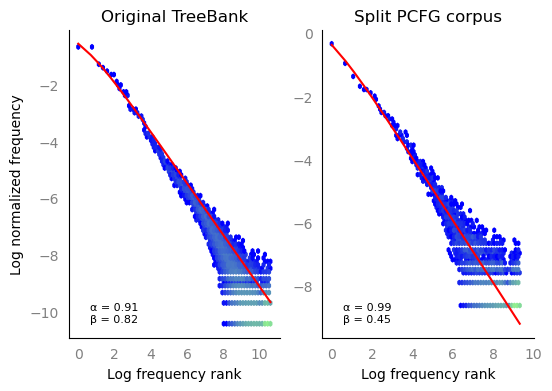

In [15]:
plot_Zipf_curve_comparison(PTB, AL, 'Original TreeBank', 'Split PCFG corpus')

## Shared levels

In [16]:
# read in shared_levels_PTB.txt
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/shared_levels_PTB.txt')
with open(shared_levels_path) as f:
    shared_levels = f.readlines()

skipped_idx = []
for i, sentence in enumerate(PTB):
    if len(sentence) >= cutoff_max or len(sentence) <= cutoff_min:
        skipped_idx.append(i)

shared_levels = [i for j, i in enumerate(shared_levels) if j not in skipped_idx]
shared_levelsPTB = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPTB)

130950

In [17]:
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/train_shared_withoutROOT.txt')
with open(shared_levels_path) as f:
    shared_levels = f.readlines()

shared_levelsPCFG = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPCFG)

105960

In [18]:
def stats_shared_levels(data, name):
    print(
        f"""
        {name:}
        The amount of labels is {len(data)}.
        There are {len(set(data))} unique labels.
        The labels are: {set(data)}.
        """
    )

In [19]:
stats_shared_levels(shared_levelsPTB, name='PTB')
stats_shared_levels(shared_levelsPCFG, name='PCFG')


        PTB
        The amount of labels is 130950.
        There are 23 unique labels.
        The labels are: {0, 1, 2, 3, 4, 5, 6, 7, -15, -14, -13, -12, -11, -2, -9, -8, -7, -6, -5, -4, -3, -1, -10}.
        

        PCFG
        The amount of labels is 105960.
        There are 27 unique labels.
        The labels are: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1}.
        


In [26]:
def plot_shared_levels(datasets, names):
    plt.hist(datasets[0], density=True, alpha=0.7, label=names[0])
    plt.hist(datasets[1], density=True, alpha=0.7, label=names[1])

    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.get_yaxis().set_visible(False) 

    plt.xlabel('Relative shared levels')
    plt.title('Relative shared levels of PTB and PCFG')
    plt.legend()

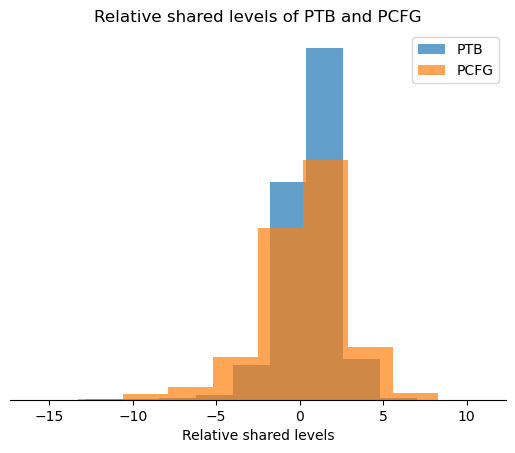

In [27]:
plot_shared_levels([shared_levelsPTB, shared_levelsPCFG], ['PTB', 'PCFG'])

## Chunking (distribution BIES labels)